# 완전 EDA Notebook (train.csv 기준)

이 노트북은 **`/mnt/data/train.csv`**를 기준으로 EDA를 **끝까지 자동 수행**하고,
`eda_output/YYYYMMDD_HHMMSS/` 아래에 리포트/그림/아티팩트를 저장합니다.


In [19]:
#from google.colab import drive
#drive.mount('/content/drive')

In [20]:
# =========================
# 0) Imports
# =========================
import os
import re
import json
import math
from datetime import datetime
from pathlib import Path
import textwrap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"   # Windows 기본 한글 폰트(맑은 고딕)
plt.rcParams["axes.unicode_minus"] = False      # 마이너스(-) 깨짐 방지

# (선택) 통계검정/모델 기반 중요도
try:
    from scipy.stats import chi2_contingency, pointbiserialr
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

try:
    from sklearn.feature_selection import mutual_info_classif
    from sklearn.preprocessing import LabelEncoder
    SKLEARN_OK = True
except Exception:
    SKLEARN_OK = False

print("SCIPY_OK:", SCIPY_OK, "| SKLEARN_OK:", SKLEARN_OK)


SCIPY_OK: True | SKLEARN_OK: True


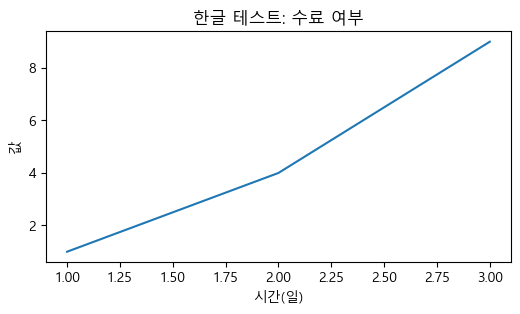

현재 font.family = ['Malgun Gothic']


In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.plot([1,2,3],[1,4,9])
plt.title("한글 테스트: 수료 여부")
plt.xlabel("시간(일)")
plt.ylabel("값")
plt.show()

print("현재 font.family =", plt.rcParams["font.family"])


In [22]:
import matplotlib.font_manager as fm

fonts = [f.name for f in fm.fontManager.ttflist]
print("Malgun Gothic" in fonts)


True


In [23]:
# =========================
# 1) Config
# =========================
TRAIN_PATH = Path(r"open/train.csv")
TARGET = "completed"
ID_COL = "ID"
OUTDIR = Path("eda_output_v1")  # 실행 시점 기준 상대경로로 생성

assert TRAIN_PATH.exists(), f"파일이 없습니다: {str(TRAIN_PATH)}"
print("TRAIN_PATH:", TRAIN_PATH.resolve())


TRAIN_PATH: C:\Users\xrtwin\Desktop\수료예측\open\train.csv


## 2) 유틸 함수 정의

In [24]:
def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def save_text(path: Path, text: str):
    path.write_text(text, encoding="utf-8")

def safe_series_to_numeric(s: pd.Series) -> pd.Series:
    """문자열/불리언 혼입 가능성을 고려해 숫자로 강제 변환(실패는 NaN)."""
    # bool은 그대로 percentile에 넣으면 TypeError 터질 수 있으니 먼저 숫자화
    if pd.api.types.is_bool_dtype(s):
        return s.astype("int8")

    # pandas nullable boolean(BooleanDtype)도 처리
    if str(s.dtype).lower() == "boolean":
        return s.astype("Int8")

    return pd.to_numeric(s, errors="coerce")

def classify_column(series: pd.Series, name: str, target_name: str):
    """컬럼 타입 자동 분류(전처리 설계용)"""
    if name == target_name:
        return "target"

    nun = series.nunique(dropna=True)
    if nun <= 1:
        return "constant"

    if series.dtype == "object":
        sample = series.dropna().astype(str).head(200)
        if len(sample) > 0:
            date_hits = sample.str.contains(r"(?:\d{4}[-/]\d{1,2}[-/]\d{1,2})|(?:\d{8})", regex=True).mean()
            if date_hits >= 0.6:
                return "datetime_like"

    n = len(series)
    uniq_ratio = nun / max(n, 1)
    if uniq_ratio >= 0.98:
        return "id_like"

    if pd.api.types.is_numeric_dtype(series):
        return "numeric_discrete" if nun <= 30 else "numeric_continuous"

    if series.dtype == "object":
        sn = safe_series_to_numeric(series)
        if sn.notna().mean() >= 0.95:
            nun_num = sn.nunique(dropna=True)
            return "numeric_discrete" if nun_num <= 30 else "numeric_continuous"

    if series.dtype == "object":
        s_str = series.dropna().astype(str)
        avg_len = s_str.map(len).mean() if len(s_str) > 0 else 0
        nun = series.nunique(dropna=True)
        if nun <= 20 and avg_len <= 40:
            return "categorical_low"
        if nun <= 200 and avg_len <= 60:
            return "categorical_high"
        return "text"

    return "unknown"

def describe_numeric(series: pd.Series):
    # object → to_numeric, bool → int 변환
    if series.dtype == "object":
        s = safe_series_to_numeric(series)
    else:
        # numeric인데 bool이면 int로
        s = series.astype("int8") if pd.api.types.is_bool_dtype(series) else series

    s = s.dropna()

    if len(s) == 0:
        return {}

    # percentile 안전하게 float로 계산
    s = s.astype(float)

    return {
        "count": int(s.shape[0]),
        "mean": float(s.mean()),
        "std": float(s.std(ddof=1)) if s.shape[0] > 1 else 0.0,
        "min": float(s.min()),
        "p1": float(np.percentile(s, 1)),
        "p5": float(np.percentile(s, 5)),
        "p25": float(np.percentile(s, 25)),
        "p50": float(np.percentile(s, 50)),
        "p75": float(np.percentile(s, 75)),
        "p95": float(np.percentile(s, 95)),
        "p99": float(np.percentile(s, 99)),
        "max": float(s.max()),
        "nunique": int(pd.Series(s).nunique()),
    }

def iqr_outlier_mask(x: pd.Series, k: float = 1.5):
    """IQR 기반 이상치 마스크 (bool/nullable-bool 포함 안전 처리)"""
    # bool이면 percentile 계산 전에 숫자화
    if pd.api.types.is_bool_dtype(x) or str(x.dtype).lower() == "boolean":
        x = x.astype("float")

    # object 등은 숫자 변환 시도
    if x.dtype == "object":
        x = safe_series_to_numeric(x)

    x = x.dropna()

    if len(x) < 8:
        return None, None, None

    # float로 고정 (percentile 안정)
    x = x.astype(float)

    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1
    lo, hi = q1 - k * iqr, q3 + k * iqr
    return lo, hi, (x < lo) | (x > hi)

def plot_missing_bar(missing_rate: pd.Series, outpath: Path, topk: int = 30):
    mr = missing_rate.sort_values(ascending=False).head(topk)
    plt.figure(figsize=(10, 6))
    plt.barh(mr.index[::-1], mr.values[::-1])
    plt.xlabel("Missing Rate")
    plt.title(f"Top {topk} Missing Rate Columns")
    plt.tight_layout()
    plt.savefig(outpath, dpi=160)
    plt.close()

def plot_target_distribution(y: pd.Series, outpath: Path):
    vc = y.value_counts(dropna=False)
    plt.figure(figsize=(5, 4))
    plt.bar(vc.index.astype(str), vc.values)
    plt.title("Target Distribution")
    plt.xlabel("completed")
    plt.ylabel("count")
    plt.tight_layout()
    plt.savefig(outpath, dpi=160)
    plt.close()

def plot_numeric_hist(series: pd.Series, name: str, outpath: Path):
    if series.dtype == "object":
        x = safe_series_to_numeric(series)
    else:
        x = series.astype("int8") if pd.api.types.is_bool_dtype(series) else series

    x = x.dropna()
    if len(x) == 0:
        return

    x = x.astype(float)  # 분위수/히스토그램 안정화
    p1, p99 = np.percentile(x, 1), np.percentile(x, 99)

    plt.figure(figsize=(7, 4))
    plt.hist(x, bins=30)
    plt.title(f"Histogram: {name}")
    plt.tight_layout()
    plt.savefig(outpath, dpi=160)
    plt.close()

    plt.figure(figsize=(7, 4))
    x_clip = x[(x >= p1) & (x <= p99)]
    plt.hist(x_clip, bins=30)
    plt.title(f"Histogram (1-99% clipped): {name}")
    plt.tight_layout()
    plt.savefig(outpath.with_name(outpath.stem + "_clipped.png"), dpi=160)
    plt.close()

def plot_numeric_by_target(df: pd.DataFrame, col: str, target: str, outpath: Path):
    # 1) x 준비: object/boolean/bool 모두 안전하게 숫자화
    s = df[col]

    if s.dtype == "object":
        x = safe_series_to_numeric(s)
    elif pd.api.types.is_bool_dtype(s) or str(s.dtype).lower() == "boolean":
        # bool → 숫자로 변환 (boxplot/percentile 안전)
        x = s.astype("float")
    else:
        x = s

    y = df[target]

    # 2) target별 분리 후 float 강제 (matplotlib percentile 안정화)
    data0 = x[y == 0].dropna().astype(float)
    data1 = x[y == 1].dropna().astype(float)

    if (len(data0) + len(data1)) == 0:
        return

    plt.figure(figsize=(6, 4))
    plt.boxplot([data0.values, data1.values], tick_labels=["0", "1"], showfliers=False)
    plt.title(f"{col} by {target} (box, no fliers)")
    plt.xlabel(target)
    plt.ylabel(col)
    plt.tight_layout()
    plt.savefig(outpath, dpi=160)
    plt.close()

def _wrap_label(s: str, width: int = 18) -> str:
    s = "" if s is None else str(s)
    s = s.replace("\n", " ").strip()
    # 너무 길면 줄바꿈
    return "\n".join(textwrap.wrap(s, width=width)) if len(s) > width else s

def plot_categorical_target_rate(df, col, target, outpath, topk=15):
    s = df[col].astype("object")
    vc = s.value_counts(dropna=False)
    cats = vc.head(topk).index

    tmp = df[df[col].isin(cats)].copy()
    if tmp.empty:
        return

    rate = tmp.groupby(col, dropna=False)[target].mean().reindex(cats)
    cnt  = tmp.groupby(col, dropna=False)[target].size().reindex(cats)

    labels = [_wrap_label(x, width=18) for x in rate.index.astype(str)]
    y = np.arange(len(labels))

    fig_h = max(4, 0.9 * len(labels) + 1)

    # rate
    plt.figure(figsize=(10, fig_h))
    plt.barh(y, rate.values)
    plt.yticks(y, labels)
    plt.xlim(0, 1)
    plt.xlabel("P(completed=1)")
    plt.title(f"{col}: Target Rate (top {topk})")
    plt.tight_layout()
    plt.savefig(outpath, dpi=160, bbox_inches="tight")
    plt.close()

    # count
    plt.figure(figsize=(10, fig_h))
    plt.barh(y, cnt.values)
    plt.yticks(y, labels)
    plt.xlabel("count")
    plt.title(f"{col}: Category Counts (top {topk})")
    plt.tight_layout()
    plt.savefig(outpath.with_name(outpath.stem + "_counts.png"), dpi=160, bbox_inches="tight")
    plt.close()

def correlation_heatmap(df_num: pd.DataFrame, outpath: Path):
    if df_num.shape[1] < 2:
        return
    corr = df_num.corr(numeric_only=True)
    plt.figure(figsize=(min(14, 0.5 * corr.shape[1] + 4), min(14, 0.5 * corr.shape[0] + 4)))
    plt.imshow(corr.values, aspect="auto")
    plt.colorbar()
    plt.xticks(range(corr.shape[1]), corr.columns, rotation=90, fontsize=7)
    plt.yticks(range(corr.shape[0]), corr.index, fontsize=7)
    plt.title("Correlation Heatmap (numeric)")
    plt.tight_layout()
    plt.savefig(outpath, dpi=180)
    plt.close()

def leakage_suspects(df: pd.DataFrame, target: str, col_types: dict):
    suspects = []
    keywords = [
        "complete", "completed", "pass", "result", "outcome", "label",
        "score", "grade", "eval", "evaluation", "final", "certificate",
        "수료", "합격", "결과", "점수", "평가", "성적", "완료"
    ]
    for c in df.columns:
        if c == target:
            continue
        lower = c.lower()
        if any(k in lower for k in keywords):
            suspects.append((c, "name_keyword"))

    y = df[target]
    for c, t in col_types.items():
        if c == target:
            continue
        if t in ("numeric_continuous", "numeric_discrete"):
            x = safe_series_to_numeric(df[c])
            ok = x.notna() & y.notna()
            if ok.sum() >= 50:
                try:
                    corr = np.corrcoef(x[ok].astype(float), y[ok].astype(float))[0, 1]
                except Exception:
                    corr = np.nan
                if np.isfinite(corr) and abs(corr) >= 0.75:
                    suspects.append((c, f"high_corr(|r|={corr:.3f})"))

    for c in df.columns:
        if c == target:
            continue
        miss = df[c].isna().astype(int)
        ok = y.notna()
        if ok.sum() >= 50:
            try:
                corr = np.corrcoef(miss[ok], y[ok].astype(int))[0, 1]
            except Exception:
                corr = np.nan
            if np.isfinite(corr) and abs(corr) >= 0.75:
                suspects.append((c, f"missing_pattern_corr(|r|={corr:.3f})"))

    return pd.DataFrame(suspects, columns=["column", "reason"]).drop_duplicates().sort_values(["reason", "column"])


## 3) 메인 EDA 함수

In [25]:
def run_eda(train_path: Path, target: str = "completed", id_col: str = "ID", outdir: Path = Path("eda_output_v1")):
    assert train_path.exists(), f"파일이 없습니다: {train_path}"

    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    base = outdir / ts
    reports = base / "reports"
    figures = base / "figures"
    artifacts = base / "artifacts"
    ensure_dir(reports); ensure_dir(figures); ensure_dir(artifacts)

    df = pd.read_csv(train_path)
    n_rows, n_cols = df.shape

    if target not in df.columns:
        raise ValueError(f"target 컬럼 '{target}' 이(가) 없습니다. 실제 타깃명을 확인하세요.")

    y = df[target]
    y_counts = y.value_counts(dropna=False)
    y_pos_rate = float((y == 1).mean()) if set(y.dropna().unique()) <= {0, 1} else float("nan")

    summary_lines = [
        f"[DATA] path={train_path}",
        f"[SHAPE] rows={n_rows}, cols={n_cols}",
        f"[COLUMNS] {list(df.columns)}",
        "",
        "[TARGET]",
        str(y_counts),
        f"pos_rate(completed=1)={y_pos_rate:.6f}",
    ]

    if id_col in df.columns:
        id_unique = df[id_col].nunique(dropna=True)
        summary_lines += ["", "[ID CHECK]", f"ID unique={id_unique} / rows={n_rows} (unique_ratio={id_unique/max(n_rows,1):.6f})"]

    save_text(reports / "00_overall_summary.txt", "\n".join(summary_lines))

    missing_rate = df.isna().mean().sort_values(ascending=False)
    nunique = df.nunique(dropna=True).sort_values(ascending=False)
    dtypes = df.dtypes.astype(str)

    pd.DataFrame({
        "dtype": dtypes,
        "nunique": nunique.reindex(df.columns).values,
        "missing_rate": missing_rate.reindex(df.columns).values,
        "missing_count": df.isna().sum().reindex(df.columns).values,
    }, index=df.columns).to_csv(reports / "01_schema_missing_unique.csv", encoding="utf-8-sig")

    dup_rows = int(df.duplicated().sum())
    save_text(reports / "02_duplicates.txt", f"duplicate_rows={dup_rows}")

    plot_missing_bar(missing_rate, figures / "missing_top30.png", topk=30)
    plot_target_distribution(y, figures / "target_distribution.png")

    col_types = {c: classify_column(df[c], c, target) for c in df.columns}
    pd.DataFrame({"column": list(col_types.keys()), "type": list(col_types.values())}).to_csv(
        reports / "03_column_types.csv", index=False, encoding="utf-8-sig"
    )

    numeric_cols = [c for c, t in col_types.items() if t in ("numeric_continuous", "numeric_discrete")]
    cat_low_cols = [c for c, t in col_types.items() if t == "categorical_low"]
    cat_high_cols = [c for c, t in col_types.items() if t == "categorical_high"]
    text_cols = [c for c, t in col_types.items() if t == "text"]
    constant_cols = [c for c, t in col_types.items() if t == "constant"]
    id_like_cols = [c for c, t in col_types.items() if t == "id_like"]
    datetime_like_cols = [c for c, t in col_types.items() if t == "datetime_like"]

    save_text(
        reports / "04_column_groups.txt",
        "\n".join([
            f"numeric_cols({len(numeric_cols)}): {numeric_cols}",
            f"cat_low_cols({len(cat_low_cols)}): {cat_low_cols}",
            f"cat_high_cols({len(cat_high_cols)}): {cat_high_cols}",
            f"text_cols({len(text_cols)}): {text_cols}",
            f"datetime_like_cols({len(datetime_like_cols)}): {datetime_like_cols}",
            f"id_like_cols({len(id_like_cols)}): {id_like_cols}",
            f"constant_cols({len(constant_cols)}): {constant_cols}",
        ])
    )

    # 수치형
    num_desc_rows, outlier_rows = [], []
    for c in numeric_cols:
        desc = describe_numeric(df[c])
        if desc:
            desc["column"] = c
            num_desc_rows.append(desc)

        x = safe_series_to_numeric(df[c]) if (df[c].dtype == "object" or pd.api.types.is_bool_dtype(df[c]) or str(df[c].dtype).lower()=="boolean") else df[c]
        lo, hi, mask = iqr_outlier_mask(x, k=1.5)
        if mask is not None:
            out_cnt = int(mask.sum())
            out_rate = float(out_cnt / max(len(x.dropna()), 1))
            outlier_rows.append({"column": c, "iqr_low": float(lo), "iqr_high": float(hi),
                                 "outlier_count": out_cnt, "outlier_rate": out_rate})

            out_idx = x.dropna().index[mask]
            cols = ([id_col] if id_col in df.columns else []) + [c, target]
            df.loc[out_idx, cols].head(10).to_csv(artifacts / f"outlier_samples__{c}.csv",
                                                  index=False, encoding="utf-8-sig")

        plot_numeric_hist(df[c], c, figures / f"hist__{c}.png")
        plot_numeric_by_target(df, c, target, figures / f"box__{c}_by_target.png")

    if num_desc_rows:
        pd.DataFrame(num_desc_rows).set_index("column").to_csv(reports / "05_numeric_describe.csv", encoding="utf-8-sig")
    if outlier_rows:
        pd.DataFrame(outlier_rows).sort_values("outlier_rate", ascending=False).to_csv(
            reports / "06_numeric_outliers_iqr.csv", index=False, encoding="utf-8-sig"
        )

    # 범주형
    cat_rows = []
    for c in (cat_low_cols + cat_high_cols):
        s = df[c].astype("object")
        vc = s.value_counts(dropna=False)
        top = vc.head(20)
        nun = int(s.nunique(dropna=True))
        miss = float(s.isna().mean())

        cat_rows.append({
            "column": c,
            "nunique": nun,
            "missing_rate": miss,
            "top20_values": "; ".join([f"{str(k)}:{int(v)}" for k, v in top.items()])
        })

        g = df.groupby(c, dropna=False)[target].agg(["count", "mean"]).reset_index()
        g = g.sort_values(["mean", "count"], ascending=[False, False])
        g.to_csv(artifacts / f"cat_target_table__{c}.csv", index=False, encoding="utf-8-sig")

        plot_categorical_target_rate(df, c, target, figures / f"cat_target_rate__{c}.png", topk=15)

        if SCIPY_OK and df[c].nunique(dropna=True) <= 50:
            s2 = df[c].astype("object").fillna("<<MISSING>>")
            ct = pd.crosstab(s2, df[target])
            if ct.shape[0] >= 2 and ct.shape[1] == 2:
                try:
                    chi2, p, dof, _ = chi2_contingency(ct.values)
                    save_text(artifacts / f"chi2__{c}.txt", f"chi2={chi2:.6f}\np={p:.6e}\ndof={dof}\nshape={ct.shape}")
                except Exception as e:
                    save_text(artifacts / f"chi2__{c}.txt", f"failed: {repr(e)}")

    if cat_rows:
        pd.DataFrame(cat_rows).sort_values(["nunique", "missing_rate"], ascending=[False, False]).to_csv(
            reports / "07_categorical_summary.csv", index=False, encoding="utf-8-sig"
        )

    # 텍스트형
    text_rows = []
    token_pat = re.compile(r"[A-Za-z0-9가-힣]+")
    for c in text_cols:
        s = df[c].astype("object")
        s_non = s.dropna().astype(str)
        lengths = s_non.map(len)
        empty_rate = float((s_non.str.strip() == "").mean()) if len(s_non) > 0 else 0.0

        sample = s_non.head(500)
        tokens = []
        for line in sample:
            tokens.extend(token_pat.findall(line.lower()))
        top_tokens = pd.Series(tokens).value_counts().head(30) if len(tokens) > 0 else pd.Series(dtype=int)
        top_token_str = "; ".join([f"{k}:{int(v)}" for k, v in top_tokens.items()])

        text_rows.append({
            "column": c,
            "missing_rate": float(s.isna().mean()),
            "avg_len": float(lengths.mean()) if len(lengths) > 0 else 0.0,
            "p50_len": float(lengths.median()) if len(lengths) > 0 else 0.0,
            "p95_len": float(np.percentile(lengths, 95)) if len(lengths) > 0 else 0.0,
            "empty_rate(non-null)": empty_rate,
            "nunique": int(s.nunique(dropna=True)),
            "top_tokens(sample500)": top_token_str
        })

        if len(lengths) > 0:
            plt.figure(figsize=(7, 4))
            plt.hist(lengths, bins=30)
            plt.title(f"Text Length Histogram: {c}")
            plt.xlabel("length")
            plt.ylabel("count")
            plt.tight_layout()
            plt.savefig(figures / f"text_len__{c}.png", dpi=160)
            plt.close()

    if text_rows:
        pd.DataFrame(text_rows).sort_values("avg_len", ascending=False).to_csv(
            reports / "08_text_columns_profile.csv", index=False, encoding="utf-8-sig"
        )

    # 결측 플래그 신호
    miss_signal = []
    y_int = df[target].astype(float)
    for c in df.columns:
        if c == target:
            continue
        miss = df[c].isna().astype(int)
        ok = y_int.notna()
        if ok.sum() >= 50:
            try:
                r = np.corrcoef(miss[ok], y_int[ok])[0, 1]
            except Exception:
                r = np.nan
            miss_signal.append({"column": c, "missing_rate": float(df[c].isna().mean()), "corr_with_target": r})
    pd.DataFrame(miss_signal).sort_values("corr_with_target", key=lambda x: x.abs(), ascending=False).to_csv(
        reports / "09_missing_flag_signal.csv", index=False, encoding="utf-8-sig"
    )

    # 수치형 타깃 상관 + 히트맵
    df_num = pd.DataFrame({
        c: (safe_series_to_numeric(df[c]) if (df[c].dtype == "object" or pd.api.types.is_bool_dtype(df[c])) else df[c])
        for c in numeric_cols
    })
    df_num[target] = df[target].astype(float)

    if df_num.shape[1] >= 3:
        correlation_heatmap(df_num.drop(columns=[target], errors="ignore"), figures / "corr_heatmap_numeric.png")

    corr_rows = []
    for c in numeric_cols:
        x = df_num[c]
        ok = x.notna() & df_num[target].notna()
        if ok.sum() >= 50:
            try:
                r = np.corrcoef(x[ok], df_num[target][ok])[0, 1]
            except Exception:
                r = np.nan
            corr_rows.append({"column": c, "corr_with_target": r, "missing_rate": float(df[c].isna().mean())})
    pd.DataFrame(corr_rows).sort_values("corr_with_target", key=lambda x: x.abs(), ascending=False).to_csv(
        reports / "10_numeric_corr_with_target.csv", index=False, encoding="utf-8-sig"
    )

    # Mutual Information(옵션)
    if SKLEARN_OK:
        X_cols = [c for c in df.columns if c != target]
        X = df[X_cols].copy().drop(columns=text_cols, errors="ignore")

        for c in X.columns:
            if pd.api.types.is_numeric_dtype(X[c]):
                continue
            sn = safe_series_to_numeric(X[c])
            if sn.notna().mean() >= 0.95:
                X[c] = sn
            else:
                X[c] = X[c].astype("object").fillna("<<MISSING>>")
                le = LabelEncoder()
                X[c] = le.fit_transform(X[c].astype(str))

        X = X.fillna(-999)
        y_mi = df[target].astype(int)
        try:
            mi = mutual_info_classif(X, y_mi, discrete_features="auto", random_state=42)
            pd.DataFrame({"column": X.columns, "mutual_info": mi}).sort_values("mutual_info", ascending=False).to_csv(
                reports / "11_mutual_info_rank.csv", index=False, encoding="utf-8-sig"
            )
        except Exception as e:
            save_text(reports / "11_mutual_info_rank.txt", f"mutual_info failed: {repr(e)}")

    leak_df = leakage_suspects(df, target, col_types)
    leak_df.to_csv(reports / "12_leakage_suspects.csv", index=False, encoding="utf-8-sig")

    # 전처리 초안
    decision_rows = []
    for c in df.columns:
        if c == target:
            continue
        miss = float(df[c].isna().mean())
        t = col_types.get(c, "unknown")

        drop_reason, recommend = "", ""
        if miss >= 0.999:
            drop_reason = "missing_~100%"; recommend = "DROP"
        elif t == "constant":
            drop_reason = "constant"; recommend = "DROP"
        elif t == "id_like" or c == id_col:
            drop_reason = "id_like"; recommend = "EXCLUDE_FROM_FEATURES"
        elif t in ("numeric_continuous", "numeric_discrete"):
            recommend = "NUMERIC(consider clip/impute/scale/binning)"
        elif t == "categorical_low":
            recommend = "CATEGORICAL_LOW(onehot + missing_as_category)"
        elif t == "categorical_high":
            recommend = "CATEGORICAL_HIGH(target/impact encoding or hashing; handle unseen)"
        elif t == "text":
            recommend = "TEXT(tfidf/char-ngram/embedding; clean/normalize)"
        elif t == "datetime_like":
            recommend = "DATETIME(parse -> year/month/day/elapsed)"
        else:
            recommend = "REVIEW"

        decision_rows.append({
            "column": c, "type": t, "missing_rate": miss,
            "nunique": int(df[c].nunique(dropna=True)),
            "recommendation": recommend, "drop_reason": drop_reason
        })

    pd.DataFrame(decision_rows).sort_values(
        ["drop_reason", "missing_rate", "nunique"], ascending=[False, False, False]
    ).to_csv(reports / "13_preprocessing_decision_draft.csv", index=False, encoding="utf-8-sig")

    done_msg = [
        "EDA DONE",
        f"output_dir={base}",
        f"reports={reports}",
        f"figures={figures}",
        f"artifacts={artifacts}",
        f"scipy={SCIPY_OK}, sklearn={SKLEARN_OK}",
    ]
    save_text(reports / "99_done.txt", "\n".join(done_msg))
    return base, done_msg


## 4) 실행

In [26]:
base, done_msg = run_eda(train_path=TRAIN_PATH, target=TARGET, id_col=ID_COL, outdir=OUTDIR)
print("\n".join(done_msg))


c:\Users\xrtwin\miniforge3\envs\hecto\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\xrtwin\miniforge3\envs\hecto\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\xrtwin\miniforge3\envs\hecto\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\xrtwin\miniforge3\envs\hecto\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\xrtwin\miniforge3\envs\hecto\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\xrtwin\miniforge3\envs\hecto\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

EDA DONE
output_dir=eda_output_v1\20260209_144032
reports=eda_output_v1\20260209_144032\reports
figures=eda_output_v1\20260209_144032\figures
artifacts=eda_output_v1\20260209_144032\artifacts
scipy=True, sklearn=True


c:\Users\xrtwin\miniforge3\envs\hecto\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\xrtwin\miniforge3\envs\hecto\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\xrtwin\miniforge3\envs\hecto\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\xrtwin\miniforge3\envs\hecto\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\xrtwin\miniforge3\envs\hecto\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\xrtwin\miniforge3\envs\hecto\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c

## 5) 핵심 결과 빠르게 미리보기

In [27]:
reports = base / "reports"
figures = base / "figures"

schema = pd.read_csv(reports / "01_schema_missing_unique.csv", index_col=0)
types = pd.read_csv(reports / "03_column_types.csv")
decision = pd.read_csv(reports / "13_preprocessing_decision_draft.csv")
leak = pd.read_csv(reports / "12_leakage_suspects.csv")

display(schema.sort_values("missing_rate", ascending=False).head(20))
display(types["type"].value_counts())
display(decision.head(20))
display(leak.head(30))

print("Example figure files:", [p.name for p in sorted(figures.glob("*.png"))[:10]])


,dtype,nunique,missing_rate,missing_count
contest_award,float64,0,1.000000,748
idea_contest,float64,0,1.000000,748
class4,float64,1,0.998663,747
contest_participation,object,6,0.991979,742
class3,float64,5,0.981283,734
previous_class_4,object,4,0.804813,602
previous_class_6,object,10,0.804813,602
previous_class_3,object,3,0.804813,602
previous_class_8,object,16,0.804813,602
previous_class_7,object,12,0.804813,602


type
categorical_low       24
categorical_high       7
numeric_discrete       6
constant               4
text                   2
id_like                1
numeric_continuous     1
target                 1
Name: count, dtype: int64

,column,type,missing_rate,nunique,recommendation,drop_reason
0,contest_award,constant,1.000000,0,DROP,missing_~100%
1,idea_contest,constant,1.000000,0,DROP,missing_~100%
2,ID,id_like,0.000000,748,EXCLUDE_FROM_FEATURES,id_like
3,class4,constant,0.998663,1,DROP,constant
4,generation,constant,0.000000,1,DROP,constant
5,contest_participation,categorical_low,0.991979,6,CATEGORICAL_LOW(onehot + missing_as_category),NaN
6,class3,numeric_discrete,0.981283,5,NUMERIC(consider clip/impute/scale/binning),NaN
7,previous_class_8,categorical_low,0.804813,16,CATEGORICAL_LOW(onehot + missing_as_category),NaN
8,previous_class_7,categorical_low,0.804813,12,CATEGORICAL_LOW(onehot + missing_as_category),NaN
9,previous_class_6,categorical_low,0.804813,10,CATEGORICAL_LOW(onehot + missing_as_category),NaN


,column,reason
0,certificate_acquisition,name_keyword
1,completed_semester,name_keyword
2,desired_certificate,name_keyword


Example figure files: ['box__class1_by_target.png', 'box__class2_by_target.png', 'box__class3_by_target.png', 'box__completed_semester_by_target.png', 'box__major_data_by_target.png', 'box__school1_by_target.png', 'box__time_input_by_target.png', 'cat_target_rate__certificate_acquisition.png', 'cat_target_rate__certificate_acquisition_counts.png', 'cat_target_rate__contest_participation.png']
